In [7]:
import datetime
import helper
import os
import pandas as pd


# All files from teslamotorsinc-my.sharepoint.com are placed under energy_data
# in this project. These files are provided seprately.
DATA_FILE_LOCATION = os.path.join(os.getcwd(), "energy_data")

# Plot data and generate metrics for:
site = 1524600080
asset = -848050549
component = 1396988257

In [8]:
# Gather data filenames for import from the file system
signal_filenames = [f for f in os.listdir(DATA_FILE_LOCATION) if "signals_data" in f]
alert_filenames = [f for f in os.listdir(DATA_FILE_LOCATION) if "alerts_data" in f]

if len(signal_filenames)==0 or len(alert_filenames)==0:
    raise Exception("ERROR: CSV data files were not found. These should be added under /energy_data")

# Import signals and alerts from all the files into dataframes.
# There is not much data so this should be okay
# Otherwise I would tackle this day by day, as pandas is all in-memory
signal_df = helper.import_csv_files(DATA_FILE_LOCATION, signal_filenames)
alert_df = helper.import_csv_files(DATA_FILE_LOCATION, alert_filenames)

# Also clean the signal data for unrealistic temperatures as explained in input_validation.ipynb
# signal_df = helper.clean_temperature_data(signal_df)

# Datetime convert the raw timestamp
signal_df["datetime_timestamp"] = pd.to_datetime(
    signal_df['timestamp'], unit='ms'
)

# Add datetime to the alert data as well
alert_df["datetime_timestamp"] = pd.to_datetime(
    alert_df['timestamp'], unit='ms'
)

array([<AxesSubplot:xlabel='datetime_timestamp'>,
       <AxesSubplot:xlabel='datetime_timestamp'>,
       <AxesSubplot:xlabel='datetime_timestamp'>,
       <AxesSubplot:xlabel='datetime_timestamp'>], dtype=object)

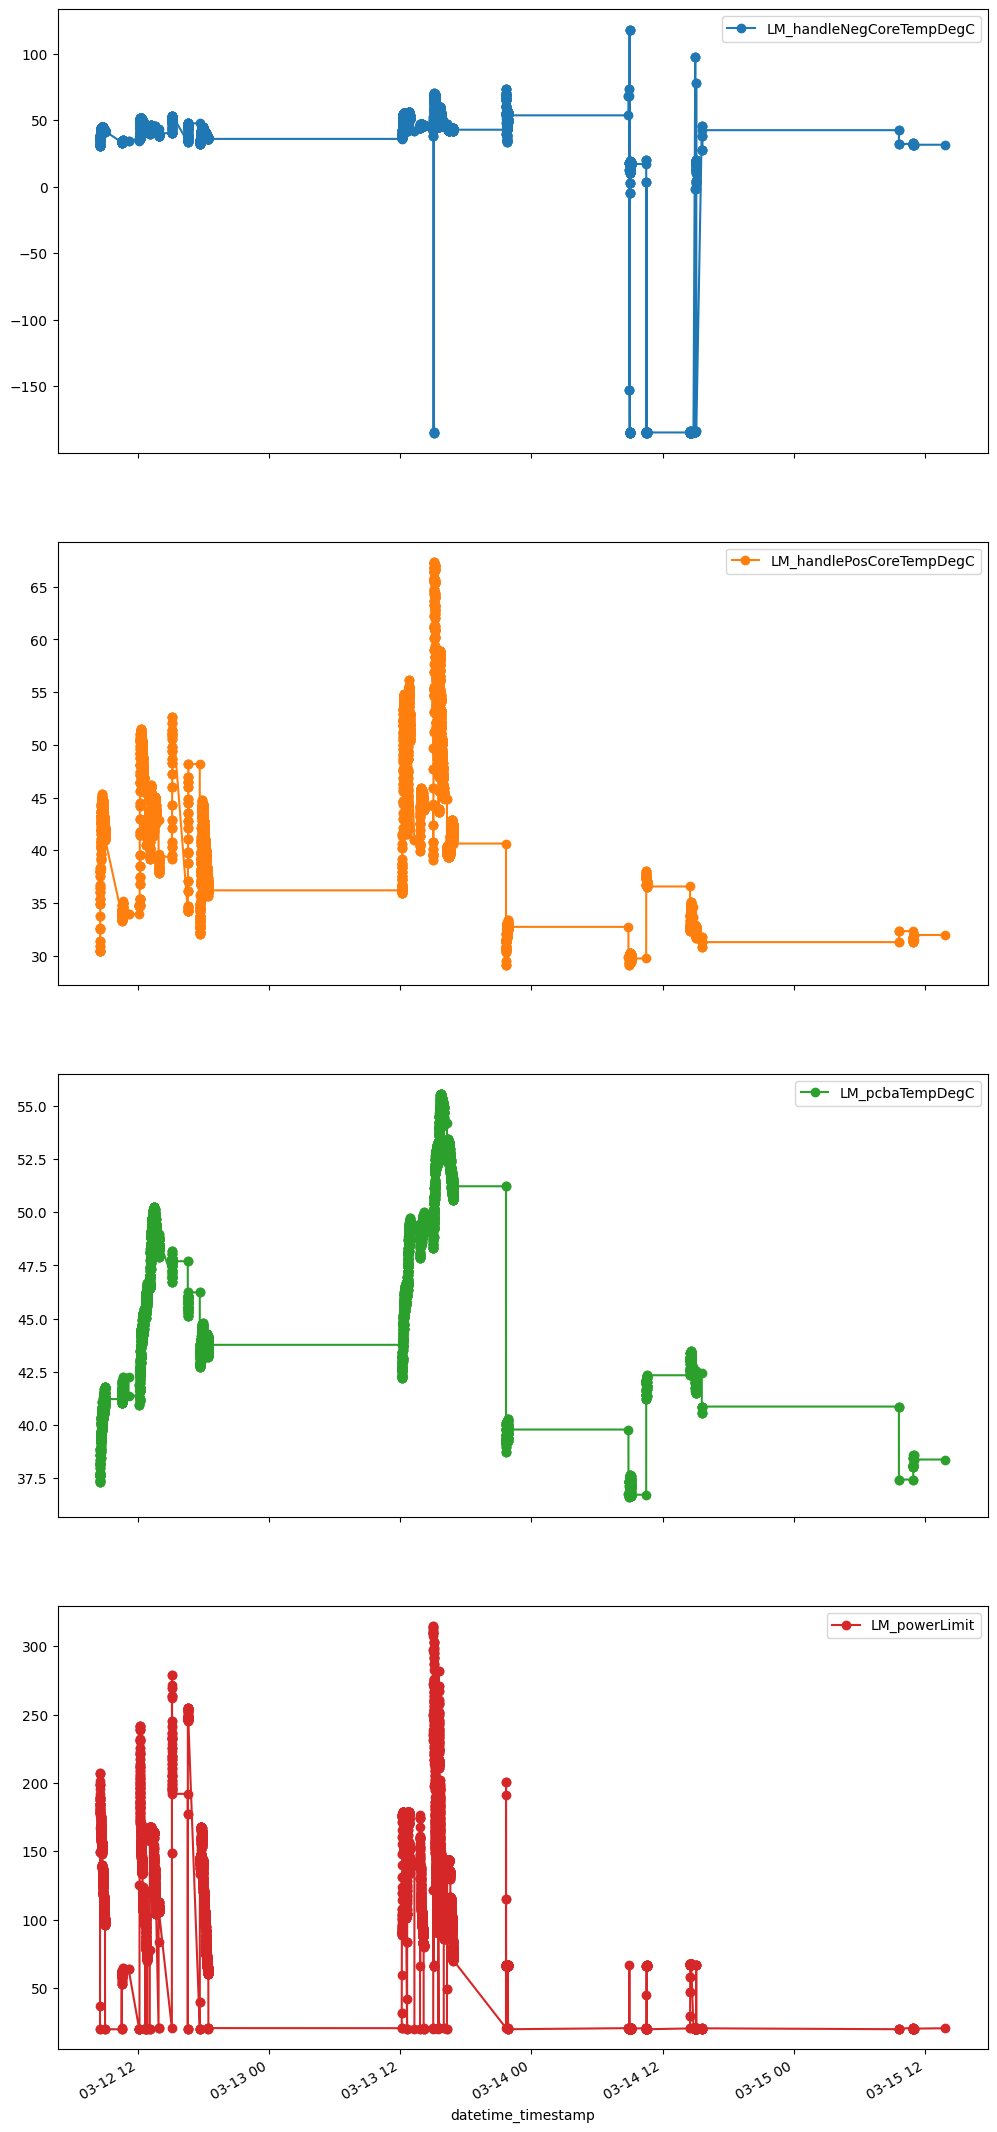

In [9]:
example_component_df = helper.filter_on_site_asset_component(signal_df, site, asset, component)

temp_df = pd.pivot_table(example_component_df,
                          index='datetime_timestamp', 
                          columns=['signal_name'],
                          values='VALUE')

temp_df.ffill().plot(subplots=True, marker="o", figsize=(12,30))

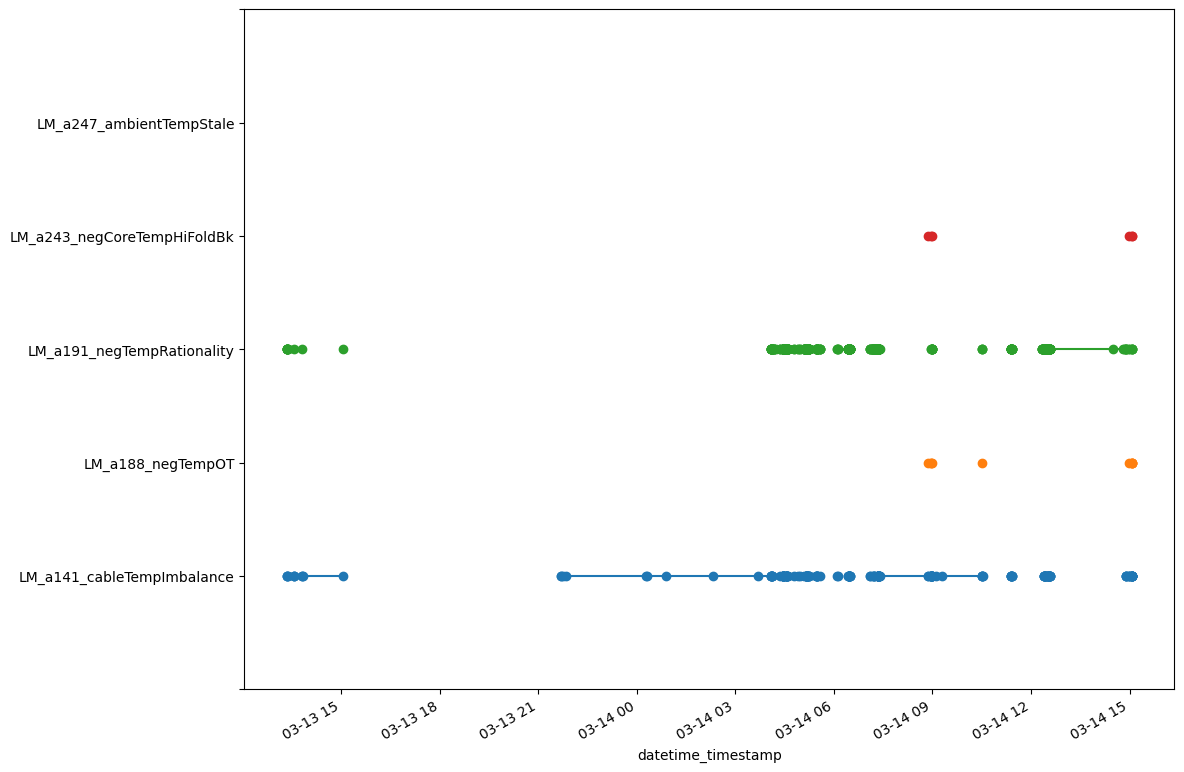

In [11]:
# Provide a y-axis number position for each unique alert for plotting reasons. {0: 'alert_name',...}
alert_y_values = {k:v for k, v in enumerate(sorted(pd.unique(alert_df['alert_name'])), start=1)}
reverse_y_values = {k:v for v, k in alert_y_values.items()}

# Annotate the alert rows with this number as well
alert_df["y_value"] = alert_df["alert_name"].map(lambda x: reverse_y_values[x])

# Plot alerts for the component we already know has a buggy negative temperature sense cable
example_component_df = helper.filter_on_site_asset_component(alert_df, site, asset, component)

if not len(example_component_df.index):
    print("No Alert Data to plot. Skipping.")
else:
  plotting_tick_labels = [''] + [v for v in alert_y_values.values()] + ['']
  plotting_tick_values = [0] + [k for k in alert_y_values.keys()] + [len(alert_y_values)+1]

  axes = pd.pivot_table(example_component_df,
                        index='datetime_timestamp', 
                        columns=['alert_name'],
                        values='y_value').plot(marker="o", 
                                              figsize=(12,10),
                                              legend=False,
                                              yticks=plotting_tick_values)

  axes.set_yticklabels(plotting_tick_labels)